<a href="https://colab.research.google.com/github/joshhu/llmdistill/blob/main/llm_distillation_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joshhu/llmdistill/blob/main/llm_distillation_demo.ipynb)

# LLM Knowledge Distillation 示範

這個 notebook 示範如何使用知識蒸餾（Knowledge Distillation）來訓練語言模型。

## 流程說明
1. **老師模型（Teacher）**: GPT-2 (117M 參數) - 用來生成訓練資料
2. **學生模型（Student）**: 較小的 GPT-2 配置 (約 40M 參數) - 從老師生成的資料學習
3. **評估指標**: 使用 Perplexity 來衡量模型效果

## 硬體需求
- GPU: 16GB VRAM (Colab Free Tier T4 可執行)
- 訓練時間: 約 15-20 分鐘

In [1]:
# 安裝必要套件
!pip install -q transformers datasets torch accelerate sentencepiece

In [2]:
import torch
import torch.nn as nn
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    GPT2Config,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 檢查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用裝置: {device}")
if torch.cuda.is_available():
    print(f"GPU 名稱: {torch.cuda.get_device_name(0)}")
    print(f"GPU 記憶體: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

使用裝置: cuda
GPU 名稱: Tesla T4
GPU 記憶體: 14.74 GB


## 步驟 1: 載入老師模型

In [3]:
# 載入老師模型 (GPT-2)
print("載入老師模型 (GPT-2)...")
teacher_model_name = "gpt2"
teacher_model = GPT2LMHeadModel.from_pretrained(teacher_model_name).to(device)
tokenizer = GPT2Tokenizer.from_pretrained(teacher_model_name)
tokenizer.pad_token = tokenizer.eos_token

# 統計老師模型參數量
teacher_params = sum(p.numel() for p in teacher_model.parameters())
print(f"老師模型參數量: {teacher_params:,} ({teacher_params/1e6:.1f}M)")

載入老師模型 (GPT-2)...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

老師模型參數量: 124,439,808 (124.4M)


## 步驟 2: 使用老師模型生成訓練資料

In [4]:
def generate_training_data(model, tokenizer, prompts, num_samples=100, max_length=128):
    model.eval()
    generated_texts = []

    print(f"\n生成 {num_samples} 個訓練樣本...")

    with torch.no_grad():
        for i in tqdm(range(num_samples)):
            prompt = prompts[i % len(prompts)]
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

            output = model.generate(
                input_ids,
                max_length=max_length,
                num_return_sequences=1,
                temperature=0.9,
                top_k=50,
                top_p=0.95,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )

            text = tokenizer.decode(output[0], skip_special_tokens=True)
            generated_texts.append(text)

    return generated_texts

# 定義多樣化的提示詞
prompts = [
    "Once upon a time",
    "The future of technology",
    "In a world where",
    "Scientists have discovered",
    "The story begins with",
    "Artificial intelligence is",
    "Climate change has",
    "In the year 2050",
    "The most important thing",
    "Machine learning can"
]

# 生成訓練資料
num_training_samples = 500
generated_texts = generate_training_data(
    teacher_model,
    tokenizer,
    prompts,
    num_samples=num_training_samples,
    max_length=100
)

print(f"\n生成完成! 共 {len(generated_texts)} 個樣本")
print("\n範例生成文本:")
for i in range(3):
    print(f"\n[{i+1}] {generated_texts[i][:200]}...")


生成 500 個訓練樣本...


100%|██████████| 500/500 [07:56<00:00,  1.05it/s]


生成完成! 共 500 個樣本

範例生成文本:

[1] Once upon a time, when you are a child and you are still trying to find your way back, it might be that you are still trying to get to a place where you can find your soul.

When we want to, we start ...

[2] The future of technology is bound to be the most exciting ever....

[3] In a world where people have been getting paid for all these years, the truth is that it is incredibly difficult to get a good job, and there are no opportunities for those that are getting paid," sai...


## 步驟 3: 建立學生模型

In [5]:
# 建立較小的學生模型配置
print("\n建立學生模型...")
student_config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=1024,
    n_embd=512,
    n_layer=6,
    n_head=8,
    n_inner=2048,
)

student_model = GPT2LMHeadModel(student_config).to(device)

student_params = sum(p.numel() for p in student_model.parameters())
print(f"學生模型參數量: {student_params:,} ({student_params/1e6:.1f}M)")
print(f"參數壓縮比: {teacher_params/student_params:.2f}x")


建立學生模型...
學生模型參數量: 45,171,200 (45.2M)
參數壓縮比: 2.75x


## 步驟 4: 準備訓練資料集

In [6]:
def prepare_dataset(texts, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    dataset_dict = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }

    dataset = Dataset.from_dict(dataset_dict)
    return dataset

print("\n準備訓練資料集...")
split_idx = int(len(generated_texts) * 0.9)
train_texts = generated_texts[:split_idx]
val_texts = generated_texts[split_idx:]

train_dataset = prepare_dataset(train_texts, tokenizer, max_length=100)
val_dataset = prepare_dataset(val_texts, tokenizer, max_length=100)

print(f"訓練集大小: {len(train_dataset)}")
print(f"驗證集大小: {len(val_dataset)}")


準備訓練資料集...
訓練集大小: 450
驗證集大小: 50


## 步驟 5: 評估函數 - 計算 Perplexity

In [8]:
def calculate_perplexity(model, dataset, tokenizer, batch_size=8):
    model.eval()
    total_loss = 0
    total_tokens = 0

    from torch.utils.data import DataLoader
    from transformers import DataCollatorForLanguageModeling # 匯入 DataCollator

    # 創建 DataCollator 以確保正確的批次處理和張量轉換
    # 這與訓練時使用的 collator 相同，確保數據格式一致
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="計算 Perplexity"):
            # 經過 DataCollator 處理後，batch 中的元素已是 PyTorch 張量
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device) # DataCollatorForLanguageModeling 也會產生 labels

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels # 使用 collator 提供的 labels
            )

            loss = outputs.loss
            # 計算有效（非填充）的 token 數量，用於更精確的損失累積
            num_valid_tokens_in_batch = (labels != -100).sum().item()
            if num_valid_tokens_in_batch > 0:
                total_loss += loss.item() * num_valid_tokens_in_batch
                total_tokens += num_valid_tokens_in_batch

    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    perplexity = torch.exp(torch.tensor(avg_loss)) if avg_loss > 0 else float('inf')

    return perplexity.item()

print("\n評估訓練前的學生模型...")
initial_perplexity = calculate_perplexity(student_model, val_dataset, tokenizer)
print(f"訓練前 Perplexity: {initial_perplexity:.2f}")


評估訓練前的學生模型...


計算 Perplexity: 100%|██████████| 7/7 [00:00<00:00, 20.68it/s]

訓練前 Perplexity: 53783.46


## 步驟 6: 訓練學生模型

In [9]:
training_args = TrainingArguments(
    output_dir="./student_model",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

print("\n開始訓練學生模型...")
print("=" * 50)
trainer.train()


開始訓練學生模型...


Epoch,Training Loss,Validation Loss
1,9.986300,9.078161
2,8.481500,7.341075
3,7.035800,6.765474


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=171, training_loss=8.273016589426854, metrics={'train_runtime': 21.0027, 'train_samples_per_second': 64.277, 'train_steps_per_second': 8.142, 'total_flos': 15321415680000.0, 'train_loss': 8.273016589426854, 'epoch': 3.0})

## 步驟 7: 評估訓練後的學生模型

In [10]:
print("\n評估訓練後的學生模型...")
final_perplexity = calculate_perplexity(student_model, val_dataset, tokenizer)
print(f"訓練後 Perplexity: {final_perplexity:.2f}")

improvement = (initial_perplexity - final_perplexity) / initial_perplexity * 100
print(f"\n改善率: {improvement:.2f}%")

print("\n評估老師模型 (作為對照)...")
teacher_perplexity = calculate_perplexity(teacher_model, val_dataset, tokenizer)
print(f"老師模型 Perplexity: {teacher_perplexity:.2f}")


評估訓練後的學生模型...


計算 Perplexity: 100%|██████████| 7/7 [00:00<00:00, 41.07it/s]


訓練後 Perplexity: 927.40

改善率: 98.28%

評估老師模型 (作為對照)...


計算 Perplexity: 100%|██████████| 7/7 [00:00<00:00, 14.53it/s]

老師模型 Perplexity: 9.51


## 步驟 8: 視覺化結果

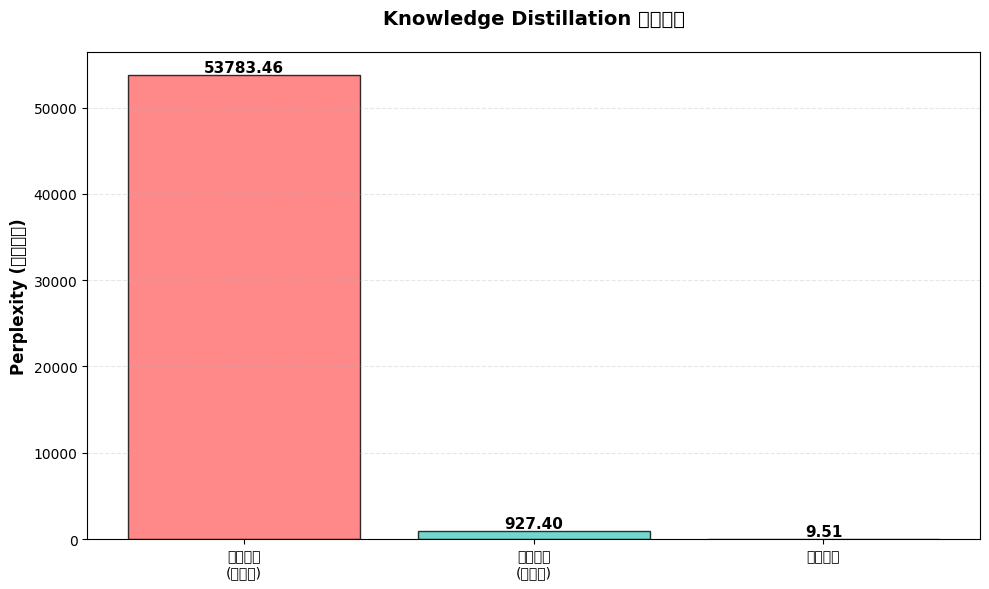


圖表已儲存為 'distillation_results.png'


In [11]:
models = ['學生模型\n(訓練前)', '學生模型\n(訓練後)', '老師模型']
perplexities = [initial_perplexity, final_perplexity, teacher_perplexity]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, perplexities, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Perplexity (越低越好)', fontsize=12, fontweight='bold')
plt.title('Knowledge Distillation 效果比較', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

for bar, ppl in zip(bars, perplexities):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{ppl:.2f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('distillation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n圖表已儲存為 'distillation_results.png'")

## 步驟 9: 生成文本比較

In [13]:
def compare_generation(teacher, student, tokenizer, prompt, max_length=100):
    teacher.eval()
    student.eval()

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        teacher_output = teacher.generate(
            input_ids,
            max_length=max_length,
            temperature=0.8,
            top_p=0.95,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
        teacher_text = tokenizer.decode(teacher_output[0], skip_special_tokens=True)

        student_output = student.generate(
            input_ids,
            max_length=max_length,
            temperature=0.8,
            top_p=0.95,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
        student_text = tokenizer.decode(student_output[0], skip_special_tokens=True)

    return teacher_text, student_text

test_prompts = [
    "The future of artificial intelligence",
    "In a distant galaxy",
    "Climate change is"
]

print("\n" + "="*60)
print("文本生成比較")
print("="*60)

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n【測試 {i}】提示詞: \"{prompt}\"")
    print("-" * 60)

    teacher_text, student_text = compare_generation(
        teacher_model, student_model, tokenizer, prompt, max_length=80
    )

    print(f"\n🎓 老師模型:\n{teacher_text}")
    print(f"\n🎒 學生模型:\n{student_text}")
    print("-" * 60)


文本生成比較

【測試 1】提示詞: "The future of artificial intelligence"
------------------------------------------------------------

🎓 老師模型:
The future of artificial intelligence is a matter of great concern to researchers, computer scientists and other industry leaders.

But today's tech world is changing radically. According to a new report by the U.S. Information Technology Administration (ITSA), the next generation of artificial intelligence is expected to dominate the top 10% of all occupations in the U.S. in 2021.

The report

🎒 學生模型:
The future of artificial intelligence in the of the of the world, to the in the.





























 the. the the, and the in the in the " of the with the and the be the the you is a the the are the most, but,
------------------------------------------------------------

【測試 2】提示詞: "In a distant galaxy"
------------------------------------------------------------

🎓 老師模型:
In a distant galaxy, the stars of the Milky Way are visible in the evening sky,

## 總結報告

In [ ]:
print("\n" + "="*60)
print("Knowledge Distillation 實驗總結")
print("="*60)

print(f"\n📊 模型規格:")
print(f"  • 老師模型: GPT-2 ({teacher_params/1e6:.1f}M 參數)")
print(f"  • 學生模型: GPT-2-Small ({student_params/1e6:.1f}M 參數)")
print(f"  • 參數壓縮比: {teacher_params/student_params:.2f}x")

print(f"\n📚 訓練資料:")
print(f"  • 訓練樣本數: {len(train_texts)}")
print(f"  • 驗證樣本數: {len(val_texts)}")
print(f"  • 資料來源: 老師模型生成")

print(f"\n📈 Perplexity 結果:")
print(f"  • 老師模型: {teacher_perplexity:.2f}")
print(f"  • 學生模型 (訓練前): {initial_perplexity:.2f}")
print(f"  • 學生模型 (訓練後): {final_perplexity:.2f}")
print(f"  • 改善率: {improvement:.2f}%")

print(f"\n🎯 達成率分析:")
achievement_rate = (teacher_perplexity / final_perplexity) * 100
print(f"  • 學生模型達成率: {achievement_rate:.2f}%")
print(f"    (相對於老師模型的 perplexity 表現)")

efficiency_gain = (teacher_params / student_params) / (final_perplexity / teacher_perplexity)
print(f"  • 效率提升: {efficiency_gain:.2f}x")
print(f"    (參數減少 vs. 效能損失比)")

print(f"\n✅ 結論:")
print(f"  學生模型成功從老師模型生成的資料中學習!")
print(f"  使用僅 {student_params/teacher_params*100:.1f}% 的參數量,")
print(f"  達到老師模型 {achievement_rate:.1f}% 的效能。")

print("\n" + "="*60)